# Supervised learning models to predicting football matches outcomes

### Notebook by [Martim Pinto da Silva](https://github.com/motapinto), [Luis Ramos](https://github.com/luispramos), [Francisco Gonçalves](https://github.com/kiko-g)
#### Supported by [Luis Paulo Reis](https://web.fe.up.pt/~lpreis/)
#### [Faculdade de Engenharia da Universidade do Porto](https://sigarra.up.pt/feup/en/web_page.inicial)

#### It is recommended to [view this notebook in nbviewer](https://nbviewer.ipython.org/github.com/motapinto/football-classification-predications/blob/master/src/Supervised%20Learning%20Models.ipynb) for the best overall experience
#### You can also execute the code on this notebook using [Jupyter Notebook](https://jupyter.org/) or [Binder](https://mybinder.org/)(no local installation required)


## Table of contents
1. * [Introduction](#Introduction)
2. * [Required libraries and models](#Required-libraries-and-models)
    - [Libraries](#Libraries)
    - [Models](#Models)
3. * [The problem domain](#The-problem-domain)
4. * [Step 1: Data analysis](#Step-1:-Data-analysis)
    - [Extracting data from the database](#Extracting-data-from-the-database)
    - [Matches](#Matches)
    - [Team Stats - Team Attributes](#Team-Stats---Team-Attributes)
    - [Team Stats - Shots](#Team-Stats---Shots)
    - [Team Stats - Possession](#Team-Stats---Possession)
    - [Team Stats - Crosses](#Team-Stats---Crosses)
    - [FIFA data](#FIFA-data)
    - [Joining all features](#Joining-all-features)
5. * [Step 2: Classification & Results Interpretation](#Step-2:-Classification-&-Results-Interpretation)
    - [Splitting the data into train and test](#Splitting-the-data-into-train-and-test)
    - [Training and Evaluating Models](#Training-and-Evaluating-Models)
    - [The basis](#The-basis)
    - [KNN](#KNN)
    - [Decision Tree](#Decision-Tree)
    - [SVC](#SVC)
    - [Naive Bayes](#Naive-Bayes)
    - [Gradient Boosting](#Gradient-Boosting)
    - [Deep Neural Network](#Deep-Neural-Network)
6. * [Conclusion](#Conclusion)
    - [What did we learn](#What-did-we-learn)
    - [Choosing best model](#Choosing-best-model)
7. * [Resources](#Resources)

## Introduction
[go back to the top](#Table-of-contents)

In the most recent years there's been a major influx of data. In response to this situation, Machine Learning alongside the field of Data Science have come to the forefront, representing the desire of humans to better understand and make sense of the current abundance of data in the world we live in.

In this notebook, we look forward to use Supervised Learning models to harness a dataset of around 25k football matches in order to be able to predict the outcome of other matchups according to a set of classes (win, draw, loss, etc.)

## Required libraries and models
[go back to the top](#Table-of-contents)

### Libraries
If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

**NumPy**: Provides a fast numerical array structure and helper functions.

**pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.

**scikit-learn**: The essential Machine Learning package for a variaty of supervised learning models, in Python.

**tensorflow**: The essential Machine Learning package for deep learning, in Python.

**matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.

### Models
Regarding the supervised learning models, we are using: 
* [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
* [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
* [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
* [XGBoost](https://xgboost.readthedocs.io/en/latest/) 
* [Deep Learning Neural Networks](https://keras.io/guides/sequential_model/)


In [1]:
# Primary libraries
from time import time
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Neural Networks
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
# Measures
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder  

Using TensorFlow backend.


## The problem domain
[go back to the top](#Table-of-contents)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that, so let's work through those questions.

#### Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

> We are trying to design a predictive model capable of accurately predicting if the home team will either win, lose or draw, i.e., predict the outcome of football matche based on a set of measurements, including player ratings, team ratings, team average stats(possession, corners, shoots), team style(pressing, possession, defending, counter attacking, speed of play, ..) and team match history(previous games)

#### Did you define the metric for success before beginning?

> Let's do that now. Since we're performing classification, we can use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) — the fraction of correctly classified matches — to quantify how well our model is performing. Knowing that most bookkeepers predict matches with an accuracy of 50%, we will try to match or beat that value. We will also use a confusion matrix, and analyse the precision, recall and f1-score. 
    
#### Did you consider whether the question could be answered with the available data?",

> The data provided has information about more than 25k matches across multiple leagues. Even though the usability isn't great, after some processing and cleansing of the data, we will be able to predict matches with great confidence. To answer the question, yes, we have more than enough data to analyse football matches..

## Step 1: Data analysis
[go back to the top](#Table-of-contents)

The first step we have, is to look at the data, and after extracting, analyse it. We know that most datasets can contain minor issues, so we have to search for  possible null or not defined values, and if so how do we proceed? Do we remove an entire row of a Dataframe? Maybe we just need to purify and substitute it's value? This analysis is done below.

Before analysing the data, we need to first extract it. For that we use multiple methods to have a cleaner code

### Extracting data from the database

In [2]:
with sqlite3.connect("../dataset/database.sqlite") as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
    team_attributes = pd.read_sql_query("SELECT distinct * from Team_Attributes",con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)

### Matches
We start by cleaning the match data and defining some methods for the data extraction and the labels

In [3]:
''' Derives a label for a given match. '''
def get_match_outcome(match):
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    outcome = pd.DataFrame()
    outcome.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match outcome  
    if home_goals > away_goals:
        outcome.loc[0,'outcome'] = "Win"
    if home_goals == away_goals:
        outcome.loc[0,'outcome'] = "Draw"
    if home_goals < away_goals:
        outcome.loc[0,'outcome'] = "Defeat"

    #Return outcome        
    return outcome.loc[0]


''' Get the last x matches of a given team. '''
def get_last_matches(matches, date, team, x = 10):
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches
    
    
''' Get the last team stats of a given team. '''
def get_last_team_stats(team_id, date, team_stats):
    #Filter team stats
    all_team_stats = teams_stats[teams_stats['team_api_id'] == team_id]
           
    #Filter last stats from team
    last_team_stats = all_team_stats[all_team_stats.date < date].sort_values(by='date', ascending=False)
    if last_team_stats.empty:
        last_team_stats = all_team_stats[all_team_stats.date > date].sort_values(by='date', ascending=True)

    #Return last matches
    return last_team_stats.iloc[0:1,:]
    
    
''' Get the last x matches of two given teams. '''
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches


''' Get the goals[home & away] of a specfic team from a set of matches. '''
def get_goals(matches, team):
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    return total_goals


''' Get the goals[home & away] conceided of a specfic team from a set of matches. '''
def get_goals_conceided(matches, team):
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


''' Get the number of wins of a specfic team from a set of matches. '''
def get_wins(matches, team):
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins 


''' Create match specific features for a given match. '''
def get_match_features(match, matches, teams_stats, x = 10):
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
     # Gets home and away team_stats
    home_team_stats = get_last_team_stats(home_team, date, teams_stats);
    away_team_stats = get_last_team_stats(away_team, date, teams_stats);
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 5)
    matches_away_team = get_last_matches(matches, date, away_team, x = 5)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
    
    #Create match features and team stats
    if(not home_team_stats.empty):
        result.loc[0, 'home_team_buildUpPlaySpeed'] = home_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'home_team_buildUpPlayPassing'] = home_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationPassing'] = home_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationCrossing'] = home_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'home_team_chanceCreationShooting'] = home_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'home_team_defencePressure'] = home_team_stats['defencePressure'].values[0]
        result.loc[0, 'home_team_defenceAggression'] = home_team_stats['defenceAggression'].values[0]
        result.loc[0, 'home_team_defenceTeamWidth'] = home_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'home_team_avg_shots'] = home_team_stats['avg_shots'].values[0]
        result.loc[0, 'home_team_avg_corners'] = home_team_stats['avg_corners'].values[0]
        result.loc[0, 'home_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]
    
    if(not away_team_stats.empty):
        result.loc[0, 'away_team_buildUpPlaySpeed'] = away_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'away_team_buildUpPlayPassing'] = away_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationPassing'] = away_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationCrossing'] = away_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'away_team_chanceCreationShooting'] = away_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'away_team_defencePressure'] = away_team_stats['defencePressure'].values[0]
        result.loc[0, 'away_team_defenceAggression'] = away_team_stats['defenceAggression'].values[0]
        result.loc[0, 'away_team_defenceTeamWidth'] = away_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'away_team_avg_shots'] = away_team_stats['avg_shots'].values[0]
        result.loc[0, 'away_team_avg_corners'] = away_team_stats['avg_corners'].values[0]
        result.loc[0, 'away_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]
    
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    result.loc[0, 'B365H'] = match.B365H
    result.loc[0, 'B365D'] = match.B365D
    result.loc[0, 'B365A'] = match.B365A
    
    #Return match features
    return result.loc[0]

''' Create and aggregate features and labels for all matches. '''
def get_features(matches, teams_stats, fifa, x = 10, get_overall = False):  
    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    #Get match features for all matches
    match_stats = matches.apply(lambda i: get_match_features(i, matches, teams_stats, x = 10), axis = 1)
    
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    #Create match outcomes
    outcomes = matches.apply(get_match_outcome, axis = 1)

    #Merges features and outcomes into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, outcomes, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    features.dropna(inplace = True)
    
    #Return preprocessed data
    return features


def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

In [4]:
viable_matches = matches
viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
count,25979.000000,25979.000000,25979.000000,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000,24158.000000,...,17097.000000,22568.000000,22568.000000,22568.000000,14162.000000,14162.000000,14162.000000,14161.000000,14161.000000,14161.000000
mean,12990.000000,11738.630317,11738.630317,18.242773,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938,0.999586,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
std,7499.635658,7553.936759,7553.936759,10.407354,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110,0.022284,...,3.632164,1.928753,1.248221,4.318338,1.489299,0.867440,3.010189,1.507793,0.868272,3.189814
min,1.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000,0.000000,...,1.100000,1.030000,1.620000,1.080000,1.050000,1.450000,1.120000,1.040000,1.330000,1.120000
25%,6495.500000,4769.000000,4769.000000,9.000000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000,1.000000,...,2.500000,1.700000,3.300000,2.550000,1.670000,3.200000,2.500000,1.670000,3.250000,2.500000
50%,12990.000000,10257.000000,10257.000000,18.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000,1.000000,...,3.500000,2.150000,3.500000,3.500000,2.100000,3.300000,3.400000,2.100000,3.400000,3.400000
75%,19484.500000,17642.000000,17642.000000,27.000000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000,1.000000,...,5.250000,2.800000,4.000000,5.400000,2.650000,3.750000,5.000000,2.620000,3.750000,5.000000
max,25979.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000,2.000000,...,41.000000,36.000000,26.000000,67.000000,21.000000,11.000000,34.000000,17.000000,13.000000,34.000000


Looking at the match data we can see that most columns have 25979 values. This means we are analysing this number of matches from the database. We can start by looking at the bookkeeper data. We can see that the number of bookkepper match data is different for each bookkeper. We start by selecting the bookeeper with the most predictions data available.

In [5]:
viable_matches = matches.sample(n=5000)
b365 = viable_matches.dropna(subset=['B365H', 'B365D', 'B365A'],inplace=False)
b365.drop(['BWH', 'BWD', 'BWA', 
          'IWH', 'IWD', 'IWA',  
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace = True, axis = 1)

bw = viable_matches.dropna(subset=['BWH', 'BWD', 'BWA'],inplace=False)
bw.drop(['B365H', 'B365D', 'B365A', 
          'IWH', 'IWD', 'IWA',  
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

iw = viable_matches.dropna(subset=['IWH', 'IWD', 'IWA'],inplace=False)
iw.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

lb = viable_matches.dropna(subset=['LBH', 'LBD', 'LBA'],inplace=False)
lb.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

ps = viable_matches.dropna(subset=['PSH', 'PSD', 'PSA'],inplace=False)
ps.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

wh = viable_matches.dropna(subset=['WHH', 'WHD', 'WHA'],inplace=False)
wh.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'SJH', 'SJD', 'SJA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

sj = viable_matches.dropna(subset=['SJH', 'SJD', 'SJA'],inplace=False)
sj.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

vc = viable_matches.dropna(subset=['VCH', 'VCD', 'VCA'],inplace=False)
vc.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA', 
          'GBH', 'GBD', 'GBA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

gb = viable_matches.dropna(subset=['GBH', 'GBD', 'GBA'],inplace=False)
gb.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA', 
          'VCH', 'VCD', 'VCA', 
          'BSH', 'BSD', 'BSA'], inplace=True, axis = 1)

bs = viable_matches.dropna(subset=['BSH', 'BSD', 'BSA'],inplace=False)
bs.drop(['B365H', 'B365D', 'B365A', 
          'BWH', 'BWD', 'BWA',  
          'IWH', 'IWD', 'IWA',
          'LBH', 'LBD', 'LBA',
          'PSH', 'PSD', 'PSA',
          'WHH', 'WHD', 'WHA',
          'SJH', 'SJD', 'SJA', 
          'VCH', 'VCD', 'VCA', 
          'GBH', 'GBD', 'GBA'], inplace=True, axis = 1)

lis = [b365, bw, iw, lb, ps, wh, sj, vc, gb, bs]

viable_matches = max(lis, key = lambda datframe: datframe.shape[0])
viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
count,4336.000000,4336.000000,4336.000000,4336.000000,4.336000e+03,4336.000000,4336.000000,4336.000000,4336.000000,4227.000000,...,4197.000000,4200.000000,4203.000000,4200.000000,4204.000000,4190.000000,4198.000000,4336.000000,4336.000000,4336.000000
mean,12025.848478,10714.286900,10714.286900,18.637454,1.199201e+06,10376.628921,10425.921125,1.537131,1.154751,0.999527,...,110888.392185,99138.700476,94287.197478,106555.633095,112523.043530,104947.980191,104762.423297,2.630996,3.841070,4.658000
std,7244.537805,7233.279055,7233.279055,10.472241,4.946720e+05,16101.500325,15448.555779,1.285535,1.115805,0.021749,...,113928.219808,109201.456342,105847.952469,115174.614665,116176.318531,111051.665027,112161.138518,1.777849,1.155116,3.763479
min,1.000000,1.000000,1.000000,1.000000,4.831310e+05,1773.000000,1773.000000,0.000000,0.000000,0.000000,...,2790.000000,2805.000000,2805.000000,2802.000000,2802.000000,2802.000000,2862.000000,1.040000,1.620000,1.170000
25%,5764.250000,4769.000000,4769.000000,10.000000,8.299498e+05,8529.000000,8533.000000,1.000000,0.000000,1.000000,...,32973.000000,30893.750000,30831.500000,32729.500000,33435.250000,31907.000000,32748.000000,1.670000,3.250000,2.500000
50%,11538.000000,10257.000000,10257.000000,18.000000,1.216886e+06,8721.000000,9748.000000,1.000000,1.000000,1.000000,...,45335.000000,40945.000000,40148.000000,42003.000000,45860.000000,41468.500000,42431.000000,2.100000,3.500000,3.500000
75%,18985.750000,17642.000000,17642.000000,27.000000,1.709826e+06,9904.000000,9906.000000,2.000000,2.000000,1.000000,...,163918.000000,150093.000000,134236.000000,157723.000000,166585.750000,159373.000000,160105.250000,2.800000,4.000000,5.250000
max,24550.000000,21518.000000,21518.000000,38.000000,2.216666e+06,274581.000000,274581.000000,10.000000,7.000000,1.000000,...,721133.000000,722766.000000,683450.000000,704523.000000,692984.000000,722766.000000,717557.000000,19.000000,17.000000,41.000000


Analysing the description of the dataframe, we can see that the bookkeper regarding Bet 365 has the most available information and, has such, we will decide to selected it as a feature input for our models

We also need to consider that some of these matches may not be on the team attributes that we will clean after this. In that case, we need to remove any matches that does not contain any team stats information, since **mean imputation** would't work in these case.

We also need to remove some rows that do not contain any information about the position of the players for some matches

In [6]:
teams_stats = team_attributes
viable_matches = viable_matches.dropna(inplace=False)

home_teams = viable_matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = viable_matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())
viable_matches = viable_matches[home_teams & away_teams]

viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
count,2493.000000,2493.000000,2493.000000,2493.000000,2.493000e+03,2493.000000,2493.000000,2493.000000,2493.000000,2493.0,...,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000
mean,11211.468913,9619.525471,9619.525471,19.545126,1.282122e+06,9358.478540,9699.275572,1.552347,1.143602,1.0,...,103978.072202,95320.695949,91689.529483,103619.532290,106036.457280,97957.247493,93896.342559,2.613658,3.850550,4.662479
std,6946.116984,6902.317566,6902.317566,10.626298,4.788375e+05,7261.740856,9821.824180,1.282118,1.105326,0.0,...,112715.737902,106002.213050,107645.226452,113000.789006,112952.461912,106327.177504,105364.152326,1.763160,1.232505,3.829519
min,1734.000000,1729.000000,1729.000000,1.000000,4.890470e+05,4087.000000,4087.000000,0.000000,0.000000,1.0,...,2790.000000,2805.000000,2805.000000,2802.000000,2802.000000,2802.000000,2983.000000,1.040000,1.620000,1.170000
25%,6161.000000,4769.000000,4769.000000,11.000000,8.755340e+05,8529.000000,8533.000000,1.000000,0.000000,1.0,...,31938.000000,30842.000000,30682.000000,31097.000000,32734.000000,30893.000000,30909.000000,1.670000,3.300000,2.600000
50%,9679.000000,7809.000000,7809.000000,20.000000,1.239705e+06,8667.000000,8686.000000,1.000000,1.000000,1.0,...,41174.000000,40444.000000,39618.000000,41694.000000,41658.000000,40601.000000,40707.000000,2.100000,3.500000,3.500000
75%,13253.000000,10257.000000,10257.000000,29.000000,1.724054e+06,9864.000000,9878.000000,2.000000,2.000000,1.0,...,154938.000000,143793.000000,116772.000000,155384.000000,157723.000000,150330.000000,134221.000000,2.800000,3.800000,5.250000
max,24550.000000,21518.000000,21518.000000,38.000000,2.060645e+06,208931.000000,208931.000000,10.000000,7.000000,1.0,...,720738.000000,722766.000000,683450.000000,704523.000000,692984.000000,722766.000000,717557.000000,19.000000,15.000000,34.000000


### Team Stats - Team Attributes

In [7]:
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


Looking at the description of team attributes we can see that there are a lot of values missing from the column buildUpPlayDribbling, and all the other values seem to have the right amout of rows. This means that there are a lot of values with 'Nan' on this column.

It's not ideal that we just drop those rows. Seems like the missing data on the column is systematic - all of the missing values are in the same column - this error could potentially bias our analysis

One way to deal with missing values is **mean imputation**. If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measure.


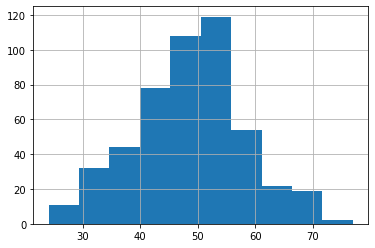

In [8]:
teams_stats['buildUpPlayDribbling'].hist();

We can see that most buildUpPlayDribbling values fall within the 45 - 55 range, so let's fill in these entries with the average measured buildUpPlaySpeed

In [9]:
build_up_play_drib_avg = teams_stats['buildUpPlayDribbling'].mean()
# mean imputation
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull()), 'buildUpPlayDribbling'] = build_up_play_drib_avg
# showing new values
teams_stats.loc[teams_stats['buildUpPlayDribbling'] == build_up_play_drib_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,48.607362,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,48.607362,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,48.607362,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,6,77,8485,2012-02-22 00:00:00,58,Balanced,48.607362,Little,62,Mixed,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,7,77,8485,2013-09-20 00:00:00,62,Balanced,48.607362,Little,45,Mixed,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover


In [10]:
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the buildUpPlayDribbling. After that, we decided to select only continuous data, i.e, select only columns that "store" numerical values that we will provide to the input of the supervised learning models.

In [11]:
teams_stats.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 
    'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass',  
    'chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass', 'defenceAggressionClass', 
    'defenceTeamWidthClass','defenceDefenderLineClass'], inplace = True, axis = 1)

teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


### Team Stats - Shots
After cleaning the team attributes data we need to consider adding some more stats to each match. We will start by adding the average of the number of shots per team. The number of shots consists on the sum of the shots on target and the shots of target. After merging all the information to teams_stats we have to analyse the data again.

In [12]:
shots_off = pd.read_csv("../dataset/shotoff_detail.csv")
shots_on = pd.read_csv("../dataset/shoton_detail.csv")
shots = pd.concat([shots_off[['match_id', 'team']], shots_on[['match_id', 'team']]])

total_shots = shots["team"].value_counts()
total_matches = shots.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_shots in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_shots = n_shots / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_shots'] = avg_shots
    
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.808530
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.470588
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.428571
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,11.376812
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000


As we can see, there are a lot of Nan values on the avg_shots column. This represents teams that did not have shots data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

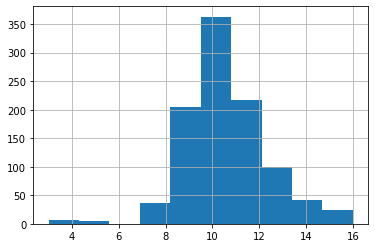

In [13]:
teams_stats['avg_shots'].hist();

We can see that most avg_shots values fall within the 7 - 14 range, so let's fill in these entries with the average measured avg_shots

In [14]:
shots_avg_team_avg = teams_stats['avg_shots'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_shots'].isnull()), 'avg_shots'] = shots_avg_team_avg
# showing new values
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000


In [15]:
teams_stats.loc[(teams_stats['avg_shots'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_shots.

### Team Stats - Possession

We will now add another stat, the ball possession. One of the more important statistics to predict the match results. If we analyse the most dominating teams usually control the ball possession very easily. We can see first that the csv have repeated values for the ball possession, for each match, based on the elapsed time of the match. We need to remove all the values that do not refer to the 90 minutes mark of the elapsed time.

In [16]:
# possessions read, cleanup and merge
possessions_data = pd.read_csv("../dataset/possession_detail.csv")
last_possessions = possessions_data.sort_values(['elapsed'], ascending=False).drop_duplicates(subset=['match_id'])
last_possessions = last_possessions[['match_id', 'homepos', 'awaypos']]

After reading it, we need to see if the number of possession data we have available is enough to be considered

In [17]:
# get the ids of the home_team and away_team to be able to join with teams later
possessions = pd.DataFrame(columns=['team', 'possession', 'match'])
for index, row in last_possessions.iterrows():
    match = matches.loc[matches['id'] == row['match_id'], ['home_team_api_id', 'away_team_api_id']]
    if match.empty:
        continue
    hometeam = match['home_team_api_id'].values[0]
    awayteam = match['away_team_api_id'].values[0]
    possessions = possessions.append({'team': hometeam, 'possession': row['homepos'], 'match': row['match_id']}, ignore_index=True)
    possessions = possessions.append({'team': awayteam, 'possession': row['awaypos'], 'match': row['match_id']}, ignore_index=True)

total_possessions = possessions.groupby(by=['team'])['possession'].sum()
total_matches = possessions.drop_duplicates(['team', 'match'])["team"].value_counts()
    
total_possessions.to_frame().describe()

,possession
count,178.000000
mean,4728.651685
std,4268.085611
min,38.000000
25%,1650.750000
50%,3690.500000
75%,6623.500000
max,17221.000000


Since the number of average possession regarding the number of viable matches is very low it doesn't make any sense to do **mean imputation** in this instance. After carefully consideration, we decided to scrap this attribute, even though this attribute as a very important meaning. This reflects the poor usability of this dataset

### Team Stats - Corners
We will try to add yet another feature. This is time the corners, also an important measurement of domination in a football match. After merging all corners data that were given to us we can see that there are some values missing.

In [18]:
corners_data = pd.read_csv("../dataset/corner_detail.csv")
corners = corners_data[['match_id', 'team']]

total_corners = corners["team"].value_counts()
total_matches = corners.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_corners in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_corners = n_corners / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_corners'] = avg_corners
    
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.916837
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,9.700000
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.591837
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.526316
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000


As we can see, there are a lot of Nan values on the avg_corners column. This represents teams that did not have corners data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

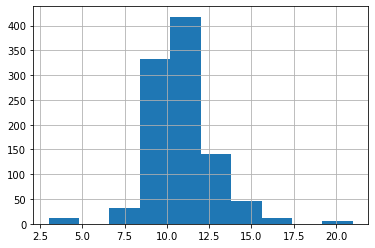

In [19]:
teams_stats['avg_corners'].hist();

We can see that most avg_corners values fall within the 8.5 - 12 range, so let's fill in these entries with the average measured avg_corners

In [20]:
corners_avg_team_avg = teams_stats['avg_corners'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_corners'].isnull()), 'avg_corners'] = corners_avg_team_avg
# showing new values
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.584839
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,10.119718
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.807166
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.105263
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_corners.

In [21]:
teams_stats.loc[(teams_stats['avg_corners'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners


### Team Stats - Crosses
The final feature to be added is the crosses data. Normally the more dominant team has more crosses because it creates more opportunity of goals during a match. After maerging all the data we need to watch for missing rows on the new added column

In [22]:
crosses_data = pd.read_csv("../dataset/cross_detail.csv")

crosses = crosses_data[['match_id', 'team']]
total_crosses = crosses["team"].value_counts()
total_matches = crosses.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_crosses in total_crosses.iteritems():
    n_matches = total_matches[index]
    avg_crosses = n_crosses / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_crosses'] = avg_crosses

teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166,15.888237
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.584839,2.815376
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000,1.500000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,10.119718,14.358974
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.807166,15.750000
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.105263,17.782895
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000,27.000000


As we can see, there are a lot of Nan values on the avg_crosses column. This represents teams that did not have crosses data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

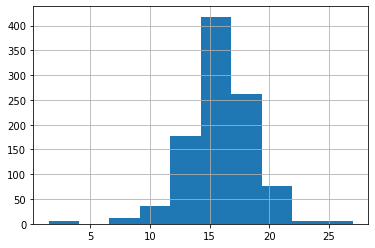

In [23]:
teams_stats['avg_crosses'].hist();

We can see that most avg_crosses values fall within the 12.5 - 17.5 range, so let's fill in these entries with the average measured avg_corners

In [24]:
crosses_avg_team_avg = teams_stats['avg_crosses'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_crosses'].isnull()), 'avg_crosses'] = crosses_avg_team_avg
# showing new values
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166,15.888237
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.584839,2.327750
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000,1.500000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,10.119718,14.971448
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.807166,15.888237
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.105263,16.671053
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000,27.000000


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_crosses.

In [25]:
teams_stats.loc[(teams_stats['avg_crosses'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses


### FIFA data
We will know gather the fifa data regarding the overrall rating of the teams

In [26]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.iloc[0]    


def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        fifa_data = pd.read_pickle(path)
        
    else:
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

In [27]:
fifa_data = get_fifa_data(viable_matches, player_attributes, None, data_exists = False)
fifa_data.describe()

Fifa data collected in 4.9 minutes


,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,home_player_10_overall_rating,...,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,match_api_id
count,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,...,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2493.000000,2.493000e+03
mean,76.144404,72.785399,74.746089,74.519053,72.499799,74.336943,74.466105,74.330124,75.156839,75.636984,...,74.477738,74.474930,72.542318,74.340955,74.235058,74.330927,75.166867,75.630164,75.679101,1.282122e+06
std,5.486376,5.082000,4.944405,5.209740,5.133266,5.327213,5.216208,5.346475,5.461733,5.630492,...,5.049753,5.362078,5.187371,5.297649,5.294166,5.377110,5.485958,5.690486,5.520474,4.788375e+05
min,55.000000,54.000000,56.000000,56.000000,52.000000,48.000000,51.000000,45.000000,51.000000,53.000000,...,55.000000,54.000000,50.000000,49.000000,48.000000,45.000000,51.000000,56.000000,53.000000,4.890470e+05
25%,73.000000,70.000000,72.000000,71.000000,69.000000,71.000000,71.000000,71.000000,72.000000,72.000000,...,72.000000,71.000000,69.000000,71.000000,71.000000,71.000000,72.000000,72.000000,72.000000,8.755340e+05
50%,76.000000,73.000000,75.000000,75.000000,73.000000,74.000000,74.000000,74.000000,75.000000,75.000000,...,74.000000,74.000000,73.000000,74.000000,74.000000,74.000000,75.000000,75.000000,75.000000,1.239705e+06
75%,80.000000,76.000000,78.000000,78.000000,76.000000,78.000000,78.000000,77.000000,79.000000,79.000000,...,78.000000,78.000000,76.000000,78.000000,78.000000,78.000000,79.000000,79.000000,79.000000,1.724054e+06
max,91.000000,87.000000,88.000000,89.000000,90.000000,92.000000,90.000000,91.000000,94.000000,94.000000,...,89.000000,89.000000,87.000000,90.000000,93.000000,91.000000,94.000000,94.000000,92.000000,2.060645e+06


### Joining all features
In this instance we need to join all features, select the input we will pass to our models, drop the column regarding the outcome label, and normalize all the features.

In [28]:
# Creates features and labels based on the provided data
viables = get_features(viable_matches, teams_stats, fifa_data, 10, False)
inputs = viables.drop('match_api_id', axis=1)
outcomes = inputs.loc[:, 'outcome']

To improve the overall measures of the supersived learning models we need to normalize our features before training our models.

In [29]:
# all features except outcomes
features = inputs.drop('outcome', axis=1)
features.iloc[:,:] = Normalizer(norm='l1').fit_transform(features)
features.head()

,home_team_buildUpPlaySpeed,home_team_buildUpPlayPassing,home_team_chanceCreationPassing,home_team_chanceCreationCrossing,home_team_chanceCreationShooting,home_team_defencePressure,home_team_defenceAggression,home_team_defenceTeamWidth,home_team_avg_shots,home_team_avg_corners,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,0.020626,0.026251,0.026251,0.026251,0.016875,0.013125,0.026251,0.013125,0.004411,0.004500,...,0.029626,0.029251,0.021376,0.027751,0.030376,0.029251,0.031126,0.031501,0.029251,0.030751
1,0.020176,0.017755,0.020983,0.024211,0.016141,0.014930,0.016141,0.018158,0.003659,0.003789,...,0.028247,0.029457,0.028650,0.027439,0.028247,0.029054,0.028247,0.028247,0.029861,0.028247
2,0.022320,0.026040,0.026040,0.026040,0.020460,0.013020,0.026040,0.013020,0.003811,0.003940,...,0.024552,0.024552,0.026784,0.025296,0.025296,0.026040,0.025296,0.026040,0.025296,0.026412
3,0.026340,0.016694,0.024856,0.016323,0.025969,0.021517,0.025598,0.017065,0.004789,0.004820,...,0.028195,0.028937,0.029308,0.026340,0.028937,0.030050,0.029308,0.030050,0.029308,0.031905
4,0.023960,0.013977,0.013977,0.027953,0.023960,0.025957,0.011980,0.017970,0.003655,0.003731,...,0.027554,0.027953,0.029151,0.028752,0.029151,0.025957,0.027953,0.029151,0.027554,0.028353


## Step 2: Classification & Results Interpretation
[go back to the top](#Table-of-contents)

### Splitting the data into train and test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size = 0.2, random_state = 40, stratify = outcomes)

### Training and Evaluating Models

used **K-Fold Cross validation**. The idea is that we split the dataset, after processing it, in k bins of equal ize

In [31]:
# Training and Evaluating Models
def train_model(clf, data, labels):
    kf = KFold(n_splits=5, shuffle=False)
    for train, test in kf.split(data):
        X_train, X_test = data[data.index.isin(train)], data[data.index.isin(test)]
        y_train, y_test = labels[data.index.isin(train)], labels[data.index.isin(test)]
        clf.fit(X_train, y_train)

def train_model_nn(clf, data, labels):
    kf = KFold(n_splits=5, shuffle=False)
    for train, test in kf.split(data):
        X_train, X_test = data[data.index.isin(train)], data[data.index.isin(test)]
        y_train, y_test = labels[data.index.isin(train)], labels[data.index.isin(test)]
        clf.fit(X_train, y_train, epochs=20, verbose=0)

def predict_outcome(clf, X_test):
    return clf.predict(X_test)

def predict_proba(clf, X_test):
    return clf.predict_proba(X_test)

def predict_metrics(y_test, y_predict):
    ls = ['Win', 'Draw', 'Defeat']
    
    from sklearn import metrics
    cm = metrics.confusion_matrix(y_test, y_predict, ls)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
    disp.plot(include_values=True, xticks_rotation='vertical')
    plt.show()
    
    print(metrics.classification_report(y_test, y_predict, target_names=ls))

    print("\n\nAccuracy score for training set: ", metrics.accuracy_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_predict, average='macro'))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict, average='macro'))
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    train_model(clf, X_train, y_train)
    y_predict = predict_outcome(clf, X_test)
    predict_metrics(y_test, y_predict)

def train_predict_nn(clf, X_train, y_train, X_test, y_test, encoder):
    train_model_nn(clf, X_train, y_train)
    y_predict = predict_outcome(clf, X_test)
    y_test_reverse = [np.argmax(y, axis=None, out=None) for y in y_test]
    y_predict_reverse = [np.argmax(y, axis=None, out=None) for y in y_predict]
    y_test_decoded = encoder.inverse_transform(y_test_reverse)
    y_predict_decoded = encoder.inverse_transform(y_predict_reverse)
    predict_metrics(y_test_decoded, y_predict_decoded)

### The basis

* The **accuracy** measure is great for balanced classes, but because this is not the case we can't do much with it.

* **Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. 

* **Precision** is a measure of the ability of a classification model to identify only the relevant data points, ie, answers the question: what portion of **predicted Positives** is truly Positive?

* **Recall** is a measure of the ability of a model to find all the relevant cases within a dataset, ie, answers the question what portion of **actual Positives** is correctly classified

* **F1-Score** is a combination of both recall and precision. Why you need this you ask? Because precision and recall are often in tension, i.e, improving one will lead to a reduction in the other, this way the f1-score is a great measure.

### KNN

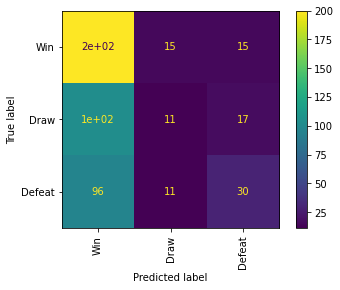

precision    recall  f1-score   support

         Win       0.48      0.22      0.30       137
        Draw       0.30      0.08      0.13       132
      Defeat       0.50      0.87      0.63       230

    accuracy                           0.48       499
   macro avg       0.43      0.39      0.36       499
weighted avg       0.44      0.48      0.41       499



Accuracy score for training set:  0.48296593186372744
Recall:  0.3906255509714729
Precision:  0.42705608834641096
F1 Score:  0.3555352291339922


In [32]:
clf = KNeighborsClassifier(n_neighbors=100)
train_predict(clf, X_train, y_train, X_test, y_test)

### Decision Tree

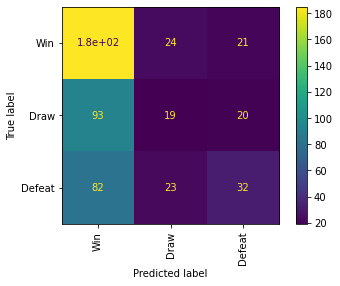

precision    recall  f1-score   support

         Win       0.44      0.23      0.30       137
        Draw       0.29      0.14      0.19       132
      Defeat       0.51      0.80      0.63       230

    accuracy                           0.47       499
   macro avg       0.41      0.39      0.37       499
weighted avg       0.43      0.47      0.42       499



Accuracy score for training set:  0.4729458917835671
Recall:  0.3939546207873723
Precision:  0.41337461371707945
F1 Score:  0.37459991358296446


In [33]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', splitter='random', max_depth=5)
train_predict(clf, X_train, y_train, X_test, y_test)

### SVC

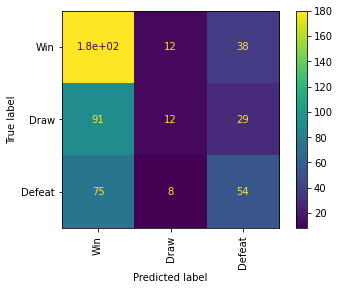

precision    recall  f1-score   support

         Win       0.45      0.39      0.42       137
        Draw       0.38      0.09      0.15       132
      Defeat       0.52      0.78      0.62       230

    accuracy                           0.49       499
   macro avg       0.45      0.42      0.40       499
weighted avg       0.46      0.49      0.44       499



Accuracy score for training set:  0.49298597194388777
Recall:  0.42255945683429025
Precision:  0.4471707352027899
F1 Score:  0.3966487048591416


In [34]:
clf = SVC(coef0=5, kernel='poly')
train_predict(clf, X_train, y_train, X_test, y_test)

### Naive Bayes

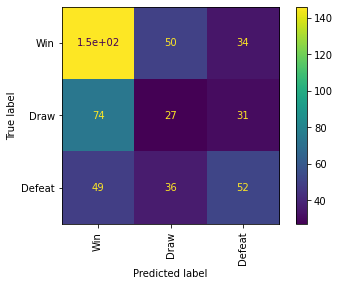

precision    recall  f1-score   support

         Win       0.44      0.38      0.41       137
        Draw       0.24      0.20      0.22       132
      Defeat       0.54      0.63      0.59       230

    accuracy                           0.45       499
   macro avg       0.41      0.41      0.41       499
weighted avg       0.44      0.45      0.44       499



Accuracy score for training set:  0.45090180360721444
Recall:  0.4062967023455757
Precision:  0.40871114230327316
F1 Score:  0.4050091076147688


In [35]:
clf = GaussianNB(var_smoothing=1.1)
train_predict(clf, X_train, y_train, X_test, y_test)

### Gradient Boosting

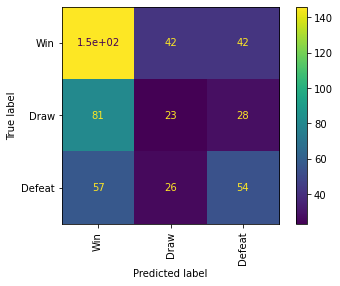

precision    recall  f1-score   support

         Win       0.44      0.39      0.41       137
        Draw       0.25      0.17      0.21       132
      Defeat       0.51      0.63      0.57       230

    accuracy                           0.45       499
   macro avg       0.40      0.40      0.40       499
weighted avg       0.42      0.45      0.43       499



Accuracy score for training set:  0.4468937875751503
Recall:  0.4010618722932275
Precision:  0.4007718769190827
F1 Score:  0.39605483852270446


In [36]:
clf = XGBClassifier(max_depth=20)
train_predict(clf, X_train, y_train, X_test, y_test)

### Deep Neural Network

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 60)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 500)               30500     
_________________________________________________________________
dense_102 (Dense)            (None, 100)               50100     
_________________________________________________________________
dense_103 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_104 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_105 (Dense)            (None, 3)                 63        
Total params: 86,733
Trainable params: 86,733
Non-trainable params: 0
______________________________________________________

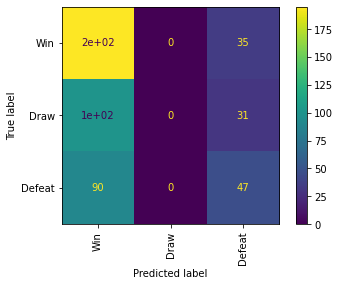

precision    recall  f1-score   support

         Win       0.42      0.34      0.38       137
        Draw       0.00      0.00      0.00       132
      Defeat       0.51      0.85      0.63       230

    accuracy                           0.48       499
   macro avg       0.31      0.40      0.34       499
weighted avg       0.35      0.48      0.40       499



Accuracy score for training set:  0.4849699398797595
Recall:  0.3969639267957262
Precision:  0.30703685023002736
F1 Score:  0.33637229437229443


In [59]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.fit_transform(y_test)
y_train2 = np_utils.to_categorical(y_train2)
y_test2 = np_utils.to_categorical(y_test2)

visible = Input(shape=(X_train.shape[1],))
hidden1 = Dense(500, activation='relu')(visible)
hidden2 = Dense(100, activation='relu')(hidden1)
hidden3 = Dense(50, activation='relu')(hidden2)
hidden4 = Dense(20, activation='relu')(hidden3)
output = Dense(3, activation='softmax')(hidden4)

clf = Model(inputs=visible, outputs=output)
print(clf.summary())

from keras import metrics
from keras import losses
from keras import optimizers

clf.compile(optimizer=optimizers.Adam(), 
              loss=losses.CategoricalCrossentropy(), 
              metrics=[metrics.Precision(), metrics.Recall()])

train_predict_nn(clf, X_train, y_train2, X_test, y_test2, le)

## Conclusion
[go back to the top](#Table-of-contents)

### What did we learn
Regarding data analysis we learn so many things we did not knew before. Regarding data analysys and processment of data, we learned the importance of usability of the dataset and in case it is not perfect we bust fixed it. After looking at our dataset we noticed some inconsistences and fixes by either removing some rows and **mean imputation** to allow the models to have multiple features. 
Before fitting the models, we noticed also, the importance of splitting in a good manner the data or train and test and used **K-Fold Cross validation**. 
Finally, the analysis of the models is very important... We cannot look only for the accuracy measure because many times it's misleading and to counter that, we must focus on other metrics to evaluate our models.


### Choosing best model

To evaluate the different models we need to choose a metric for comparison. The accuracy is only useful when we are dealing with a balanced dataset, which is not the case. Because of that, we need to consider only the other 3 possible metric, **recall**, **precison** or **f-measure**.

Since a predicton is associated with a cost in our case (given that to predict a match we have to spend money to bet on it), the most valuable measure is the precision. Then, our objective is to try to get the maximum percentage of **true positives** that are correctly classified by our models. 

In other cases, such as for medical applications, the objective of a model is to maximize the recall. The f1-score is also an important measure to evaluate both the recall and the precision, when the 2 have the same importance.

Considering this, we think that the Support Vector Machine model was the most affective. Was the one that got the most precision alongside the Naive Bayes model. The difference is that the Decision Tree model had not only the best precision but also higher f1-score, recall and accuracy. The test were done thoroughly and exastive, with shuffling the data and measuring more than once obviously.

### All in all
All in all, it was a great experience and very valuable. We noticed the interest of the professors to shift the lecture to do a more pratical work, that way we can learn much more by ourself, learn with our mistakes, and become very interest in this topic and to pursue it in future years

## References

[go back to the top](#Table-of-contents)

* [Europen Soccer Database](https://www.kaggle.com/hugomathien/soccer)

* [Football Data Analysis](https://www.kaggle.com/pavanraj159/european-football-data-analysis#The-ultimate-Soccer-database-for-data-analysis-and-machine-learning)

* [Data Analysis and Machine Learning Projects](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb)

* [Match Outcome Prediction in Football](https://www.kaggle.com/airback/match-outcome-prediction-in-football)

* [European Soccer Database Supplementary (XML Events to CSV)](https://www.kaggle.com/jiezi2004/soccer)

* [A deep learning framework for football match prediction](https://link.springer.com/article/10.1007/s42452-019-1821-5)

* [Predicting Football Match Outcome using Machine Learning: Football Match prediction using machine learning algorithms in jupyter notebook](https://github.com/prathameshtari/Predicting-Football-Match-Outcome-using-Machine-Learning)

* [(PDF) Football Result Prediction by Deep Learning Algorithms](https://www.researchgate.net/publication/334415630_Football_Result_Prediction_by_Deep_Learning_Algorithms)

* [Predicting Football Results Using Machine Learning Techniques](https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf)

* [A machine learning framework for sport result prediction](https://www.sciencedirect.com/science/article/pii/S2210832717301485)